In [1]:
import os

import numpy as np
import scipy

from sklearn.decomposition.nmf import _initialize_nmf
import cvxpy
import stft

from wav import wavPlayer, load_wav
from nmf import ANLS, subproblem

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting routine

In [2]:
def plot_spectrogram(signal, title):
    """
    Plot spectrogram of the signal using STFT and params described below in the code.
    
    Args:
        signal(ndarray): 1D-signal
        title(str): title of the plot
        
    Return:
        None
    """
    
    # here vmax=60 is put empirically for this exact audio files
    plt.specgram(signal, 
                 NFFT=framelength, 
                 Fs=fs, 
                 noverlap=framelength - hopsize, 
                 window=mlab.window_hanning, 
                 vmax=60)
    
    plt.xlim([0, len(signal) * 1. / fs])
    plt.grid("on")
    plt.title(title, fontsize=14)
    plt.xlabel("Time, s", fontsize=14)
    plt.ylabel("Frequency, Hz", fontsize=14)

In [3]:
def plot_signal(signal, title):
    """
    Plot value of the signal.
    
    Args:
        signal(ndarray): 1D-signal
        title(str): title of the plot
        
    Return:
        None
    """
    
    plt.plot(np.arange(len(signal)) * 1. / fs, signal)
    plt.title(title, fontsize=14)
    plt.ylim([-20000, 20000])
    plt.xlabel("Time, s", fontsize=12)
    plt.grid("on")

# Experiment parameters

Below one can find the parameter which are used for the Short-Term Fourier Transformation through which we get spectrogram of a signal.

* $\text{framelength} = 512$ $-$ size of the sliding window inside which the FFT is computed
* $\text{hopsize} = 128$ $-$ step size for the window
* $\text{window} = \text{hanning}$ $-$ window to use

Important thing for choosing all these parameters is the relation between frame length and hop size. 

In case of reconstruction of not modified spectrum magnitudes there is a precise relation for the perfect window size. For Hanning window hop size should be halved frame lenght. This size is taken from the following considerations: window ideally should sum to constant (preferably equal to 1) over the movements to enable Inverse STFT tranformation work perfectly. 

But we're going to reconstruct signal from the modified spectrum magnitudes. In this case the best option is to choose hop size in such manner that overlapping between consequetive windows is 75%. For further explanation see [here](https://ccrma.stanford.edu/~jos/parshl/Choice_Hop_Size.html). We do exactly like this.

In [4]:
framelength = 512
hopsize = 128
window = scipy.signal.hanning

Visualizing window

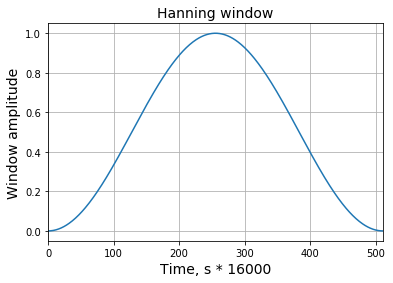

In [5]:
plt.plot(window(framelength))
plt.grid("on")
plt.xlim([0, framelength-1])
plt.title("Hanning window", fontsize=14)
plt.xlabel("Time, s * 16000", fontsize=14)
plt.ylabel("Window amplitude", fontsize=14)
plt.show()

Different windows indeed sum to $1$

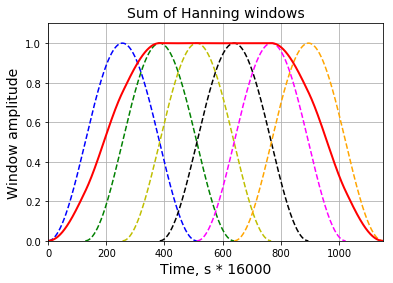

In [6]:
steps = 6
# consequtive windows
colors = ["b", "g", "y", "k", "magenta", "orange"]
for step in range(steps):
    plt.plot(np.arange(hopsize * step, hopsize * step + framelength), window(framelength), "--", c=colors[step])
# their sum
total_window = np.zeros(framelength + hopsize * (steps - 1))
for step in range(steps):
    total_window[hopsize * step : hopsize * step + framelength] += window(framelength)
# plotting
plt.plot(np.arange(total_window.shape[0]), total_window / np.max(total_window), "r", linewidth=2)
plt.grid("on")
plt.xlim([0, total_window.shape[0] - 1])
plt.ylim([0, 1.1])
plt.title("Sum of Hanning windows", fontsize=14)
plt.xlabel("Time, s * 16000", fontsize=14)
plt.ylabel("Window amplitude", fontsize=14)
plt.show()

# Reading data

## Clean speech

Loading clean speech wav file using routine from wav.py

In [7]:
fs, s_clean = load_wav('../data/chime/clean/F01_22GC010A_BTH.CH1.wav')

/usr/local/lib/python3.5/dist-packages/scipy/signal/signaltools.py:2236: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/usr/local/lib/python3.5/dist-packages/scipy/signal/signaltools.py:2238: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]


Visualizing clean speech signal

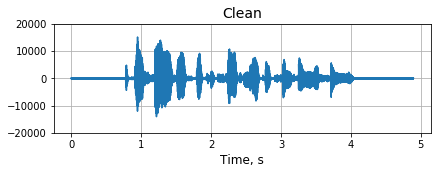

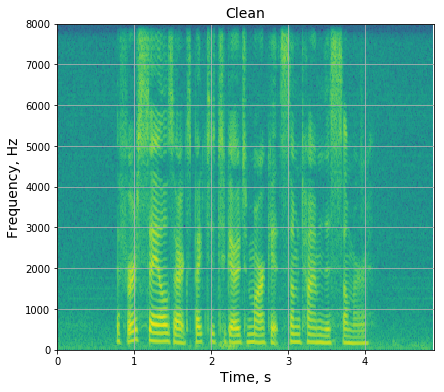

In [8]:
plt.figure(figsize=(6.75,2))
plot_signal(s_clean, "Clean")
# plt.savefig("../presentation/clean_signal.png", bbox_inches="tight")
plt.show()
plt.figure(figsize=(6.75, 6))
plot_spectrogram(s_clean, "Clean")
# plt.savefig("../presentation/clean_spec.png", bbox_inches="tight")

wavPlayer(s_clean, fs)

## Noisy speech

Loading noisy speech wav file using routine from wav.py

In [9]:
fs, s_speech= load_wav('../data/chime/noisy/caf_simu/F01_22GC010A_CAF.CH1.wav')

/usr/local/lib/python3.5/dist-packages/scipy/signal/signaltools.py:2236: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/usr/local/lib/python3.5/dist-packages/scipy/signal/signaltools.py:2238: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]


Visualizing noisy speech signal

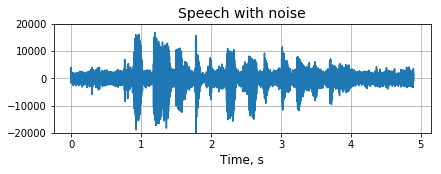

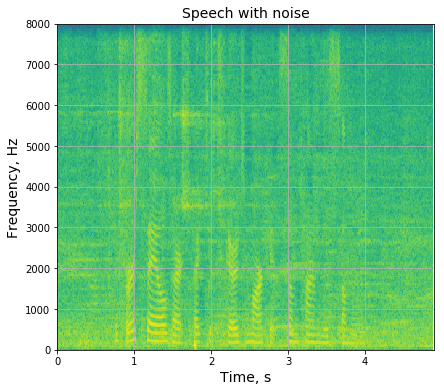

In [10]:
plt.figure(figsize=(6.75,2))
plot_signal(s_speech, "Speech with noise")
# plt.savefig("../presentation/speech_signal.png", bbox_inches="tight")
plt.show()
plt.figure(figsize=(6.75, 6))
plot_spectrogram(s_speech, "Speech with noise")
# plt.savefig("../presentation/speech_spec.png", bbox_inches="tight")

wavPlayer(s_speech, fs)

## Background

Loading background noise wav file using routine from wav.py

In [11]:
fs, s_noise = load_wav('../data/chime/backgrounds/noise.wav')

/usr/local/lib/python3.5/dist-packages/scipy/signal/signaltools.py:2236: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/usr/local/lib/python3.5/dist-packages/scipy/signal/signaltools.py:2238: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]


Visualizing background noise signal

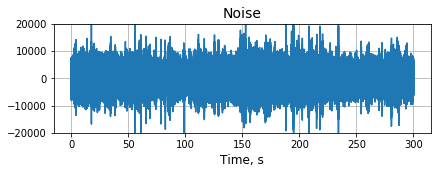

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


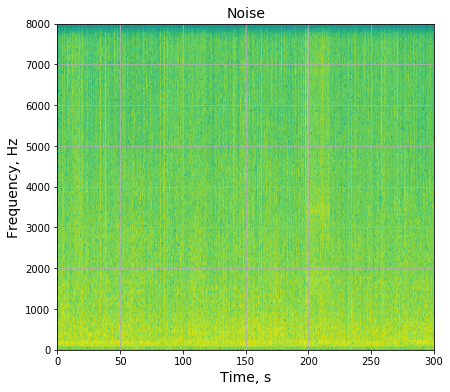

In [12]:
plt.figure(figsize=(6.75,2))
plot_signal(s_noise, "Noise")
# plt.savefig("../presentation/noise_signal.png", bbox_inches="tight")
plt.show()
plt.figure(figsize=(6.75, 6))
plot_spectrogram(s_noise, "Noise")
# plt.savefig("../presentation/noise_spec.png", bbox_inches="tight")

wavPlayer(s_noise, fs)

## Building spectrograms

Here we build spectrograms of all three signals using [STFT](https://github.com/nils-werner/stft) python library.

Spectrogram itself is a complex matrix. To obtain the real one from it we take the absolute value. In terms of physics it corresponds to the magnitude of each frequency. By doing this transformation we lost explicit information about the phase. But because the windows are overlapping we store this information implicitly and can reconstruct phase later.

In [13]:
S_clean = stft.spectrogram(s_clean, framelength, hopsize, window=window)
S_clean = np.array(S_clean)

V_clean = np.abs(S_clean)

In [14]:
S_speech = stft.spectrogram(s_speech, framelength, hopsize, window=window)
S_speech = np.array(S_speech)

V_speech = np.abs(S_speech)

In [15]:
S_noise = stft.spectrogram(s_noise, framelength, hopsize, window=window)
S_noise = np.array(S_noise)

V_noise = np.abs(S_noise)

# Learning Clean and Noise vocabularies

Here we learn frequency "building blocks" for our signals - clean speech and noise. See report or presentation for further details.

We use the best of the tested methods - ANLS (for comparison of different methods see Optimization_Demo.ipynb)

Hidden dimension ($\text{rank}$) of clean speech is choosen approximately equal to the number of phonemes (distinct "building blocks" of speech) in the English language $\approx 40$.

Our final setting is:
* $\text{r}_{\text{clean}} = 40$
* $\text{r}_{\text{noise}} = 40$

In [16]:
r_clean = 40
r_noise = 40

In [17]:
W_clean, H_clean = ANLS(V_clean, max_iter=100, rank=r_clean)

print ("Relative error of Clean speech decomposition:", np.round(np.linalg.norm(V_clean - W_clean.dot(H_clean)) / 
                                                                np.linalg.norm(V_clean), 3))

Relative error of Clean speech decomposition: 0.102


In [18]:
W_noise, H_noise = ANLS(V_noise, max_iter=200, rank=r_noise)

print ("Relative error of Noise decomposition:", np.round(np.linalg.norm(V_noise - W_noise.dot(H_noise)) / 
                                                         np.linalg.norm(V_noise), 3))

Relative error of Noise decomposition: 0.172


# Denoising

Next step is to construct the joined vocabulary $\text{W}_{\text{basis}}$ $-$ basis for the future denoising. Then denoising itself is done by simply projecting onto this basis and taking the appropriate clean component.

For the purpose of projection we use subroutine from ANLS with $\text{W}$ matrix fixed.

In [19]:
W_basis = np.hstack((W_clean, W_noise))

Initialization for components of projection

In [20]:
_, H_basis_init = _initialize_nmf(V_speech, r_clean + r_noise)

Projection itself. Here the number of iterations is significantly more than if the subroutine for ANLS. This is becaus we need to do the projection as precise as possible, while in ANLS algorithm it is just the way of choosing the step.

In [21]:
H_basis = subproblem(V_speech, W_basis, H_basis_init, sub_iter=1000)


In [22]:
print ("Relative error of Noisy decomposition:", np.round(np.linalg.norm(V_speech - W_basis.dot(H_basis)) / 
                                                         np.linalg.norm(V_speech), 
                                                         3))

Relative error of Noisy decomposition: 0.154


Reconstruction of clean speech spectrogram magnitudes

In [23]:
V_reconstructed = W_clean.dot(H_basis[:r_clean])
V_remaining = W_noise.dot(H_basis[r_clean:])

# Signal reconstruction from STFT

The last but not the least step of the algorithm is to reconstruct the phase of the signal from the magnitudes. It is possible because sliding windows was overlapped at the stage of spectrogram building.

Wew used few algorithms for that:
* Naive $-$ take null phase
* Noisy $-$ take phase from the initial noisy signal
* Iterative $-$ method prososed byu Griffin & Lim in [1](http://ieeexplore.ieee.org/document/1164317/), [2](http://dsp.stackexchange.com/questions/3406/reconstruction-of-audio-signal-from-its-absolute-spectrogram/3410#3410)
* VAD (voice activity detector) $-$ extimates proportion of speech in each cell of the complex spectrogram of the initial signal

For further details on each method see the full report.

In [24]:
V_reconstructed.shape

(257, 613)

In [25]:
def naive_reconstruction(V_reconstructed):
    """
    Implement naive reconstruction of a signal by spectrum magnitude.
    This is simply assigning zero phase.
    
    Args:
        V_reconstructed(ndarray): matrix of magnitudes
        
    Return:
        s_naive(ndarray): 1D signal reconstructed from input matrix with thre parameters 
                          defined above in the code
    """
    
    s_naive = stft.ispectrogram(V_reconstructed, framelength, hopsize, window=window)
    return s_naive

In [26]:
def noisy_reconstruction(V_reconstructed, S_speech):
    """
    Implement 'noisy' reconstruction of a signal by spectrum magnitude.
    This is simply adding phase of the initial noisy signal.
    
    Args:
        V_reconstructed(ndarray): matrix of magnitudes
        S_speech(ndarray): initial spectrogram from where to take phases
        
    Return:
        s_noisy(ndarray): 1D signal reconstructed from input matrix with thre parameters 
                          defined above in the code
    """
    
    s_noisy = stft.ispectrogram(V_reconstructed * np.exp(1j * np.angle(S_speech)), 
                                framelength, hopsize, window=window)
    return s_noisy

In [27]:
def iterative_reconstruction(V_reconstructed, signal_length, max_iter=10, return_history=True):
    """
    Implement iterative Griffin & Lim reconstruction of a signal by spectrum magnitude.
    
    Args:
        V_reconstructed(ndarray): matrix of magnitudes
        signal_length(int): length of the signal to reconstruct
        max_iter(int): maximum number of iterations
        return_hist(bool): whether to return all the reconstructed signal during
                           the iterations or just the latest one
        
    Return:
        s_iterative(ndarray): 1D signal reconstructed from input matrix with thre parameters 
                              defined above in the code
    """
    
    xk = np.random.random(signal_length) * 100
    xks = [xk]
    for i in range(max_iter):
        X = stft.spectrogram(xk, framelength, hopsize, window=window)
        Z = V_reconstructed * np.exp(1j * np.angle(X))
        xk = stft.ispectrogram(Z, framelength, hopsize, window=window)
        xks.append(xk)
    if return_history:
        return xks
    else:
        return xks[-1]

In [28]:
def vad_reconstruction(V_reconstructed, V_remaining, S_speech):
    """
    Implement VAD reconstruction of a signal by spectrum magnitude.
    This estimates the proportion of the clean speech in each cell
    of the initial spectrogram and multiply it by the corresponding
    value
    
    Args:
        V_reconstructed(ndarray): matrix of magnitudes of supposedly clean speech
        V_remaining(ndarray): matrix of magnitudes of supposedly background noise
        S_speech(ndarray): initial spectrogram
        
    Return:
        s_vad(ndarray): 1D signal reconstructed from input matrix with thre parameters 
                        defined above in the code
    """
    
    s_vad = stft.ispectrogram(S_speech * V_reconstructed / (V_reconstructed + V_remaining), 
                              framelength, 
                              hopsize, 
                              window=window)
    return s_vad

Reconstruction using all the methods

In [29]:
s_naive = naive_reconstruction(V_reconstructed)
s_noisy = noisy_reconstruction(V_reconstructed, S_speech)
s_iterative = iterative_reconstruction(V_reconstructed, len(s_clean), return_history=True)
s_vad = vad_reconstruction(V_reconstructed, V_remaining, S_speech)

/usr/local/lib/python3.5/dist-packages/stft/utils.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicetuple]
/usr/local/lib/python3.5/dist-packages/stft/utils.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicetuple]


Visualization

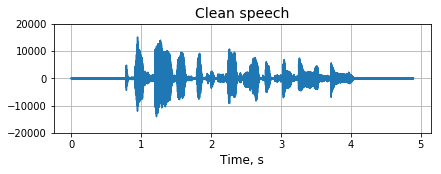

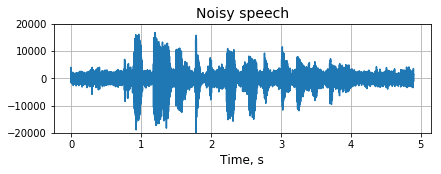

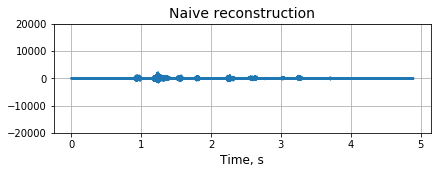

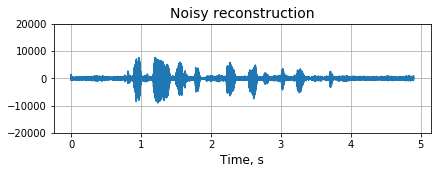

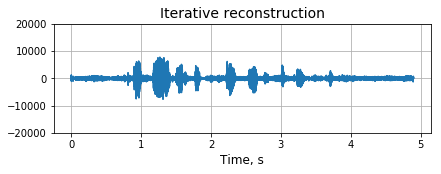

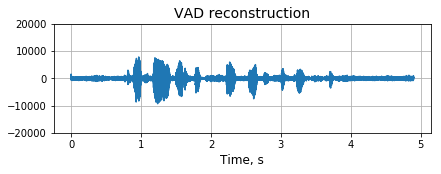

In [30]:
for sig, name in zip([s_clean, s_speech, s_naive, s_noisy, s_iterative[-1], s_vad], 
                     ["Clean speech", 
                      "Noisy speech", 
                      "Naive reconstruction", 
                      "Noisy reconstruction", 
                      "Iterative reconstruction", 
                      "VAD reconstruction"]):
    plt.figure(figsize=(6.75,2))
    plot_signal(sig, name)
    plt.show()
    wavPlayer(np.array(sig, dtype=np.int16), fs)

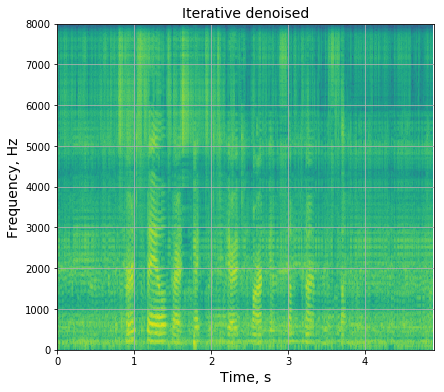

In [31]:
plt.figure(figsize=(6.75, 6))
plot_spectrogram(s_iterative[-1], "Iterative denoised")
# plt.savefig("../presentation/denoised_spec.png", bbox_inches="tight")

### Error tracing for iterative reconstruction method

The convergence of the iterative Griffin & Lim method can be measured in terms of so called Spectral convergence. That is as simple as taking the frobenius norm of the difference between spectrogram of the known clean signal and spectrogram of reconstructed signal at each step.

In [32]:
s_iterative_spectrograms = map(lambda x: np.array(np.abs(stft.spectrogram(x, 
                                                                          framelength, 
                                                                          hopsize, 
                                                                          window=window))), 
                               s_iterative)
spec_norm_evolution = map(lambda x: np.linalg.norm(x - V_clean) / np.linalg.norm(V_clean), 
                          s_iterative_spectrograms)

In [33]:
plt.plot(spec_norm_evolution[:15])
plt.grid("on")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Relative Frobenius error", fontsize=14)
plt.title("Griffin & Lim magnitudes to signal\n Spectral convergence", fontsize=14)
# plt.savefig("../presentation/griffin&lim.png", bbox_inches="tight")

TypeError: 'map' object is not subscriptable

The convergence is pretty fast but not very good 